# ReProjectingMapping Blaueu's 1664 Terrarium Orbis

Here I will try to re-project Blaueu's stereographic projection into a modern equirectangular projection.

In [1264]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from copy import deepcopy

import uuid

In [1265]:
blaueu1664 = imread('/Users/patrickfoley/map_projections/input_images/Blaeu_1664.jpg')

This is [Joan Blaueu's](https://en.wikipedia.org/wiki/Joan_Blaeu) 1664 Terrarium Orbis - a [stereographic projection](https://en.wikipedia.org/wiki/Stereographic_projection) with two hemishpheres.  My goal is to reproject it with a cylindrical projection. 

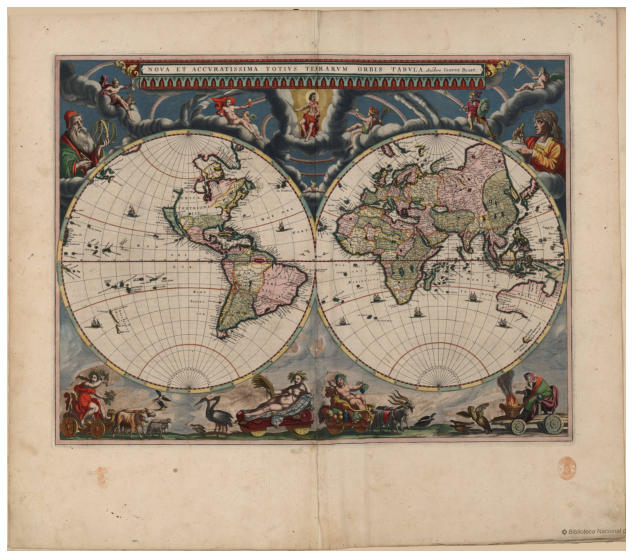

In [1308]:
plt.figure(figsize=(14, 10))
plt.imshow(blaueu1664)
_ = plt.axis('off')

Just like in the Blaueu rotations notebook, let's first crop and find the hemispheres.

In [1267]:
cropped_blau = blaueu1664[600:5400, 600:7000, :]

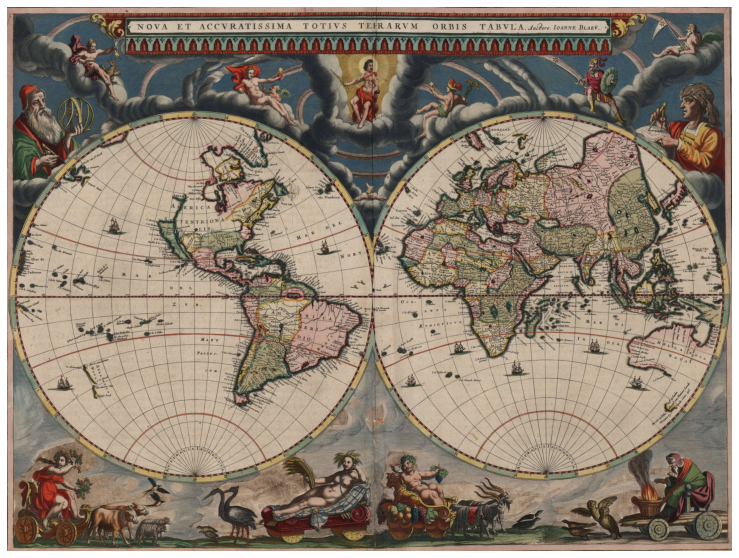

In [1307]:
plt.figure(figsize=(14,10))
plt.imshow(cropped_blau)
_ = plt.axis('off')

Looks good!  Now let's get both hemispheres. 

In [1270]:
def get_hemisphere(center, radius, base=cropped_blau):
    """Pulls a single hemisphere from a double hemisphere map.
    Center is (x,y) pixels, radius is in pixels.
    Start from cropped.
    """
    cx, cy = center
    assert cx > radius
    assert cy > radius
    nxbase, nybase, _ = base.shape
    assert nxbase - cx > radius
    assert nybase - cy > radius
    square = deepcopy(base[(cx-radius):(cx+radius), (cy-radius):(cy+radius), :])
    #  Need to make other pixels black.  Or maybe not.  
    #  square is now shape r, r, 3
    npix = 2*radius + 1
    xs, ys = np.meshgrid(np.arange(0, npix-1), np.arange(0, npix-1))
    out_of_circle = (xs - (npix/2))**2 + (ys-(npix/2))**2 > radius**2
    square[xs[out_of_circle], ys[out_of_circle], :] = 0
    return square


In [1271]:
western_hemisphere = get_hemisphere((2560, 1650), 1575)

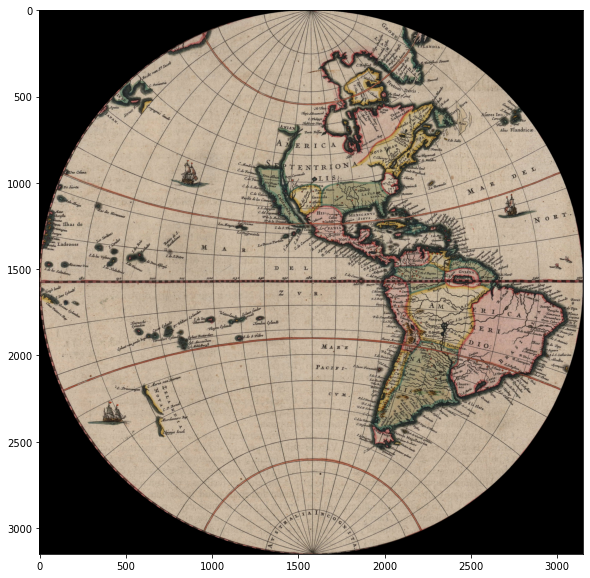

In [1272]:
plt.figure(figsize=(10,10))
plt.imshow(western_hemisphere)

In [1273]:
cropped_blau.shape

(4800, 6400, 3)

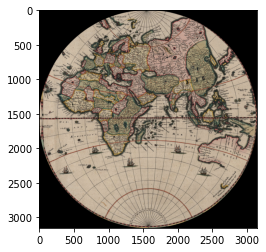

In [1274]:
eastern_hemisphere = get_hemisphere((2560, 4755), 1575)
plt.imshow(eastern_hemisphere)

Let me find the hemispheres on a smaller image for faster prototyping.

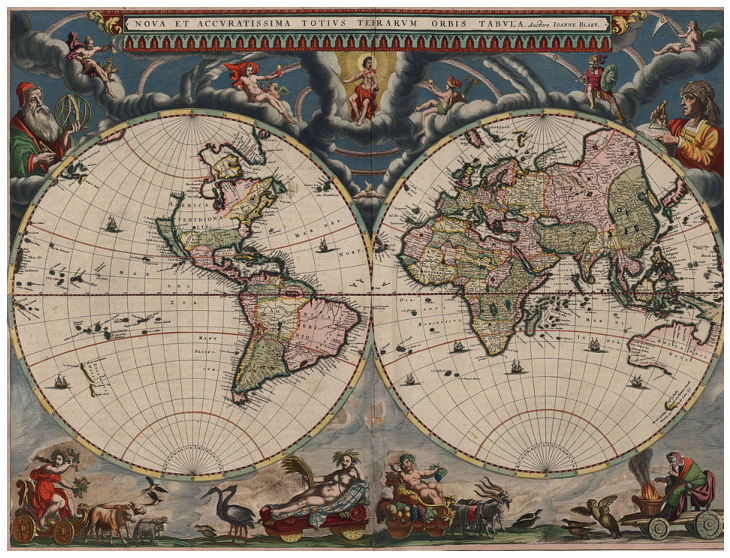

In [1306]:
small_base_img = imread('/Users/patrickfoley/map_projections/blaueu_large.jpg')
small_cropped_blau = small_base_img[95:820, 95:1050, :]
plt.figure(figsize=(14,10))
plt.imshow(small_cropped_blau)
_ = plt.axis('off')

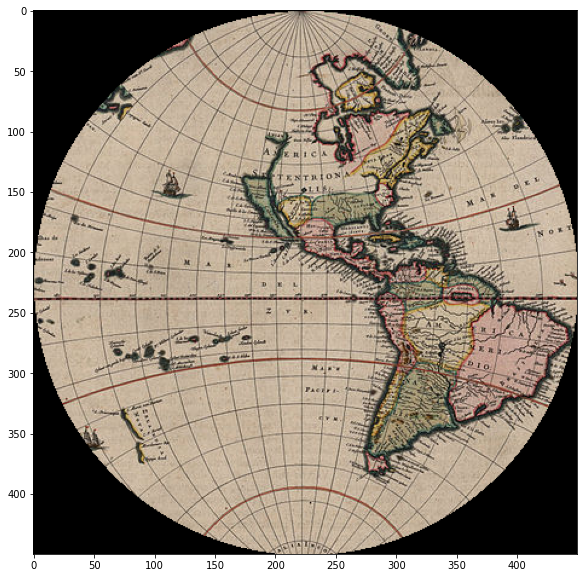

In [1276]:
small_western_hemisphere = get_hemisphere((370, 250), 225, base=small_cropped_blau)
plt.figure(figsize=(10,10))
plt.imshow(small_western_hemisphere)

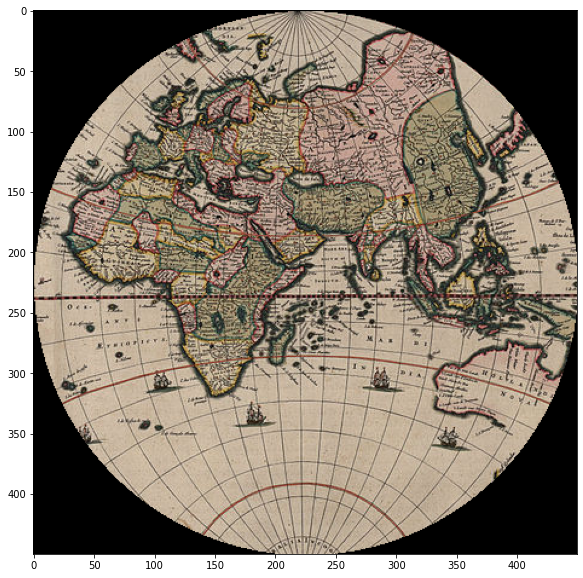

In [1277]:
small_eastern_hemisphere = get_hemisphere((370, 720), 225, base=small_cropped_blau)
plt.figure(figsize=(10,10))
plt.imshow(small_eastern_hemisphere)
small_rad = 225

## Plan

1.  Choose grid for equirectangular projection
2.  Get us, vs for grid (kind of the same as 1)
3.  Get the implied longitudes and latitudes
4.  Get x, y, z on a unit sphere
5.  Get implied u, v, H for a stereographic
6.  Resolve the continuous u, v, H into pixel selections
7.  assign pixel values from original to the new map.

### Steps 1 & 2

Remember the basic rule for all cylindrical projections:

\begin{eqnarray}
  x &=& R(\lambda - \lambda_0)cos \phi_1 \\
  y &=& R(\phi - \phi_1) 
\end{eqnarray}

For longitude $\lambda$, latitude $\phi$, radius of globe $R$, pixel coordinates x and y, standard parallels $\phi_1$, and central meridian $\lambda_0$.  This is all straight copied from Wikipedia.  

For Plate-carre, $\phi_1=0$, so we have

$x = \lambda$
$y = \phi$

Say longitude goes 0 to 2 pi, latitude -pi/2 to pi/2, so thats a 2pi * pi map.  So if I want a 2000x1000 pixel map, that's fine.

Let me start with a 400x200 for easier prototyping.

In [1278]:
# Switched it to make a big map after sorting things out
nx = 4800
ny = 2400

In [1279]:
longitudes = np.linspace(0, 0.999*2*np.pi, nx)
latitudes = np.linspace(-0.999*np.pi/2.0, 0.999*np.pi/2.0, ny)

Now let me get a mesh grid of those together.

In [1280]:
grid_longs, grid_lats = np.meshgrid(longitudes, latitudes)

### Steps 3 and 4

I actually kind of already did step 3 automatically, since plate carre is pretty simple.  It's basically just using longitude and latitude as your x and y.

So step 4 is then going to unit-sphere x/y/z.  No problem.

In [1282]:
#  These functions (and most of the others) are pasted
#  from other notebooks or the one .py file.  I do not like
#  that this is all jupyter notebooks and copy pasted stuff,
#  but nbd.

def rotationMatrix(axis_vector, angle):
    axis_vector = axis_vector / np.sqrt(sum(axis_vector**2))
    (x, y, z) = axis_vector

    tensor_product_matrix = np.matrix([
        [x**2, x * y, x * z],
        [x * y, y**2, y * z],
        [x * z, y * z, z**2]
    ])
    cross_product_matrix = np.matrix([
        [0.0, -z, y],
        [z, 0.0, -x],
        [-y, x, 0.0]
    ])
    R = np.eye(3) * np.cos(angle) + \
        cross_product_matrix * np.sin(angle) + \
        tensor_product_matrix * (1 - np.cos(angle))

    return R

def xyzFromLongLat(longs, lats):
    x = np.cos(longs) * np.cos(lats)
    y = np.sin(longs) * np.cos(lats)
    z = np.sin(lats)
    
    return (x, y, z)



xs, ys, zs = xyzFromLongLat(grid_longs, grid_lats)
to_rotate = np.stack([xs, ys, zs])
old_shape = to_rotate.shape
new_shape = [3, np.prod(xs.shape)]

ready_to_rotate = np.reshape(to_rotate, new_shape)

test_newxyz = np.dot(flipXZ, ready_to_rotate)
print(old_shape, new_shape)
newx = test_newxyz[0, :]
newx2 = newx.reshape(xs.shape)


(3, 2400, 4800) [3, 11520000]


In [1283]:
rotateX = rotationMatrix(axis_vector=np.array([1.0, 0.0, 0.0]), angle=-np.pi/2)
rotateY = rotationMatrix(axis_vector=np.array([0.0, 1.0, 0.0]), angle=np.pi/2.0)
rotateZ = rotationMatrix(axis_vector=np.array([0.0, 0.0, 1.0]), angle=-np.pi/4)

def xyzFromLongLat(longs, lats):
    """This is specialized for the Blaueu dual stereographic East/West orientation.
    I found the rotations by just testing things out with small ones.
    """
    x = np.cos(longs) * np.cos(lats)
    y = np.sin(longs) * np.cos(lats)
    z = np.sin(lats)
    
    # first axis is now x, y, z
    og_shape = x.shape
    to_rotate = np.stack([x, y, z])
    new_shape = [3, np.prod(xs.shape)]
    ready_to_rotate = np.reshape(to_rotate, new_shape)
    
    new_xyz = np.dot(rotateY, ready_to_rotate)
    new_xyz = np.dot(rotateX, new_xyz)
    #new_xyz = np.dot(one_more_bump, new_xyz) 

    new_x = new_xyz[0, :].reshape(og_shape)
    new_y = new_xyz[1, :].reshape(og_shape)
    new_z = new_xyz[2, :].reshape(og_shape)
    
    return (new_x, new_y, new_z)

In [1284]:
xs, ys, zs = xyzFromLongLat(grid_longs, grid_lats)

### Step 5

Great!  Now let's get the implied pixel positions on a stereographic projection.

This is a bit tough since we first have to resolve 'western' and 'eastern'.

I'm going to just split this based on the z-axis being above or below 0.  I could be wrong, we might want to do this with x or y, but we can go with z first and see what we get.

Update: z is correct.

In [1285]:
western_hem = zs <= 0.0
eastern_hem = zs > 0.0

us = xs / (1 - zs)
vs = ys / (1 - zs)

us = np.multiply((zs <= 0.0),(xs / (1 - zs))) + np.multiply(zs > 0.0, (xs / (1 + zs)))
vs = np.multiply((zs <= 0.0),(ys / (1 - zs))) + np.multiply(zs > 0.0, (-ys / (1 + zs)))

I initially did this without the required flipping, but then added in the flipping afterwards.  It's like you need to do another rotation for the 'southern' hemisphere.

In [1286]:
print(np.min(xs), np.max(xs))
print(np.min(ys), np.max(ys))
print(np.min(zs), np.max(zs))

-0.9999987662997035 0.9999987662997035
-0.999999786065797 0.9999997778342721
-0.9999997840079158 0.9999997675448659


In [1287]:
print(np.min(us), np.max(us))
print(np.min(vs), np.max(vs))

-0.9999987662997035 0.9999987662997035
-0.999999786065797 0.9988208298095543


### Step 6

Now this part might be tough.  When we went from points on the sphere into points on the stereographic plane, we never set a radius for the plot, so we could end up with some strange things.

Our goal here is to resolve our 'u' and 'v' values into pixel values from the original image.  Let's check some basic shapes and ranges.


In [1288]:
western_hemisphere.shape

(3150, 3150, 3)

In [1289]:
us.shape

(2400, 4800)

In [1290]:
print(western_hemisphere.shape)
print(small_western_hemisphere.shape)
print(us.shape)

(3150, 3150, 3)
(450, 450, 3)
(2400, 4800)


I've deleted a lot of comments here, but it was a good bit of trial and error.

In [1291]:
def scaleIntoImage(us, vs, og_img):
    min_us = np.min(us)
    max_us = np.max(us)
    min_vs = np.min(vs)
    max_vs = np.max(vs)

    range_new_x = max_us - min_us
    range_new_y = max_vs - min_vs
    
    # the way these images work,
    # I might be mixing up x,y / y,x here:
    n_source_x, n_source_y, n_rgb = og_img.shape
    
    us_in_source = (us - min_us) * (n_source_x * 1.0 / range_new_x)
    vs_in_source = (vs - min_vs) * (n_source_y * 1.0 / range_new_y)
    
    us_in_source[us_in_source == n_source_x] = n_source_x - 1
    vs_in_source[vs_in_source == n_source_y] = n_source_y - 1
    
    return us_in_source.astype(np.int), vs_in_source.astype(np.int)

In [1292]:
new_img = np.zeros(shape=(ny, nx, 3))

Yea, it's confusing to me a bit, but 200x400 shows up as something with more x-length than y-length.

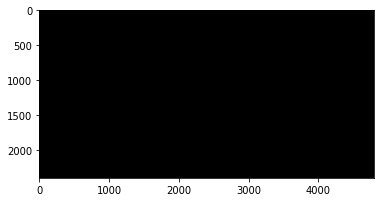

In [1294]:
plt.imshow(new_img)  # just making sure I got the shape right.  I've mixed up x and y a ton.

In [1295]:
us_in_og, vs_in_og = scaleIntoImage(us, vs, western_hemisphere)

In [1296]:
us_in_og_pix = np.floor(us_in_og).astype(np.int)
vs_in_og_pix = np.floor(vs_in_og).astype(np.int)

In [1297]:
print(np.min(us_in_og_pix), np.max(us_in_og_pix))
print(np.min(vs_in_og_pix), np.max(vs_in_og_pix))

0 3149
0 3149


In [1298]:
us_in_og_pix.shape

(2400, 4800)

In [1299]:
small_western_hemisphere.shape

(450, 450, 3)

In [1300]:
us.shape

(2400, 4800)

In [1301]:
new_img[:, :, 0] = np.multiply(western_hem, western_hemisphere[us_in_og_pix, vs_in_og_pix, 0]) + \
    np.multiply(eastern_hem, eastern_hemisphere[us_in_og_pix, vs_in_og_pix, 0]) 
new_img[:, :, 1] = np.multiply(western_hem, western_hemisphere[us_in_og_pix, vs_in_og_pix, 1]) + \
    np.multiply(eastern_hem, eastern_hemisphere[us_in_og_pix, vs_in_og_pix, 1])
new_img[:, :, 2] = np.multiply(western_hem, western_hemisphere[us_in_og_pix, vs_in_og_pix, 2]) + \
    np.multiply(eastern_hem, eastern_hemisphere[us_in_og_pix, vs_in_og_pix, 2])

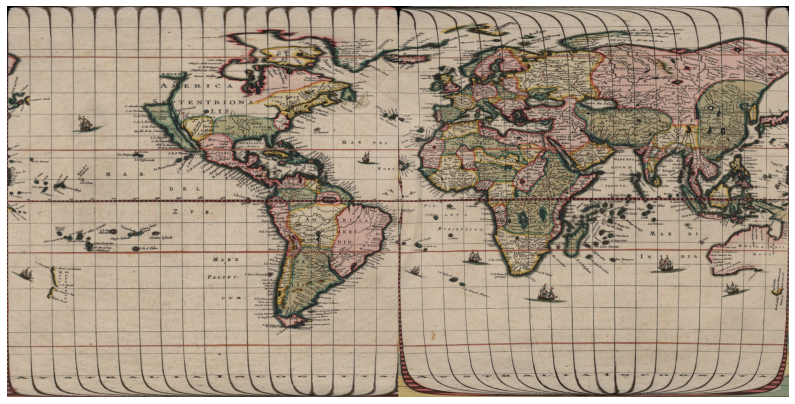

In [1305]:
new_img = new_img.astype(np.int)
plt.figure(figsize=(14,10))
plt.imshow(new_img)
_ = plt.axis('off')

In [1303]:
imwrite('~/platecarre_blau_higherrez3.jpg', new_img)

Lossy conversion from int64 to uint8. Range [0, 239]. Convert image to uint8 prior to saving to suppress this warning.


Nice!  Looks great!  The artefacts at the poles are due a bit to the curvature of the scanned image and a bit to me not being exact when choosing the bounds.